In [1]:
%load_ext autoreload
%load_ext watermark
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from interpret import show
from interpret.perf import ROC
from interpret.data import ClassHistogram
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
%watermark -v -m -p numpy,pandas,matplotlib,scikit-learn,rise,interpret,jupyter -g

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

numpy       : 1.20.3
pandas      : 1.3.4
matplotlib  : 3.4.3
scikit-learn: 1.0.1
rise        : 5.7.1
interpret   : 0.2.7
jupyter     : 1.0.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

Git hash: 60c56b60b3030d9f95b4128e7b86d484347ab760



# Agenda

- InterpretML Overview
- Explainable Boosting Machines Deep Dive
    - GAM, GAAM
    - EBM
    - Benchmark Comparison
- Demo

# Overview
- Supports explainability
    - glassbox: ML models designed for interpretability (e.g.: linear models, rule lists, generalized additive models)
    - blackbox: Techniques for explaining models (e.g. Partial Dependence, LIME, etc)
- Built-in, extensible visualization
- Explainable Boosting Machine Implementation
    - Interpretable yet comparable performance to blackbox models like RF and XGBoost
- Fast predictions and ONNX runtime conversions available

# Architecture & API
 <div style="width: 100%; overflow: hidden;">
     <div style="width: 70%; float: center; margin: 0 auto;">
         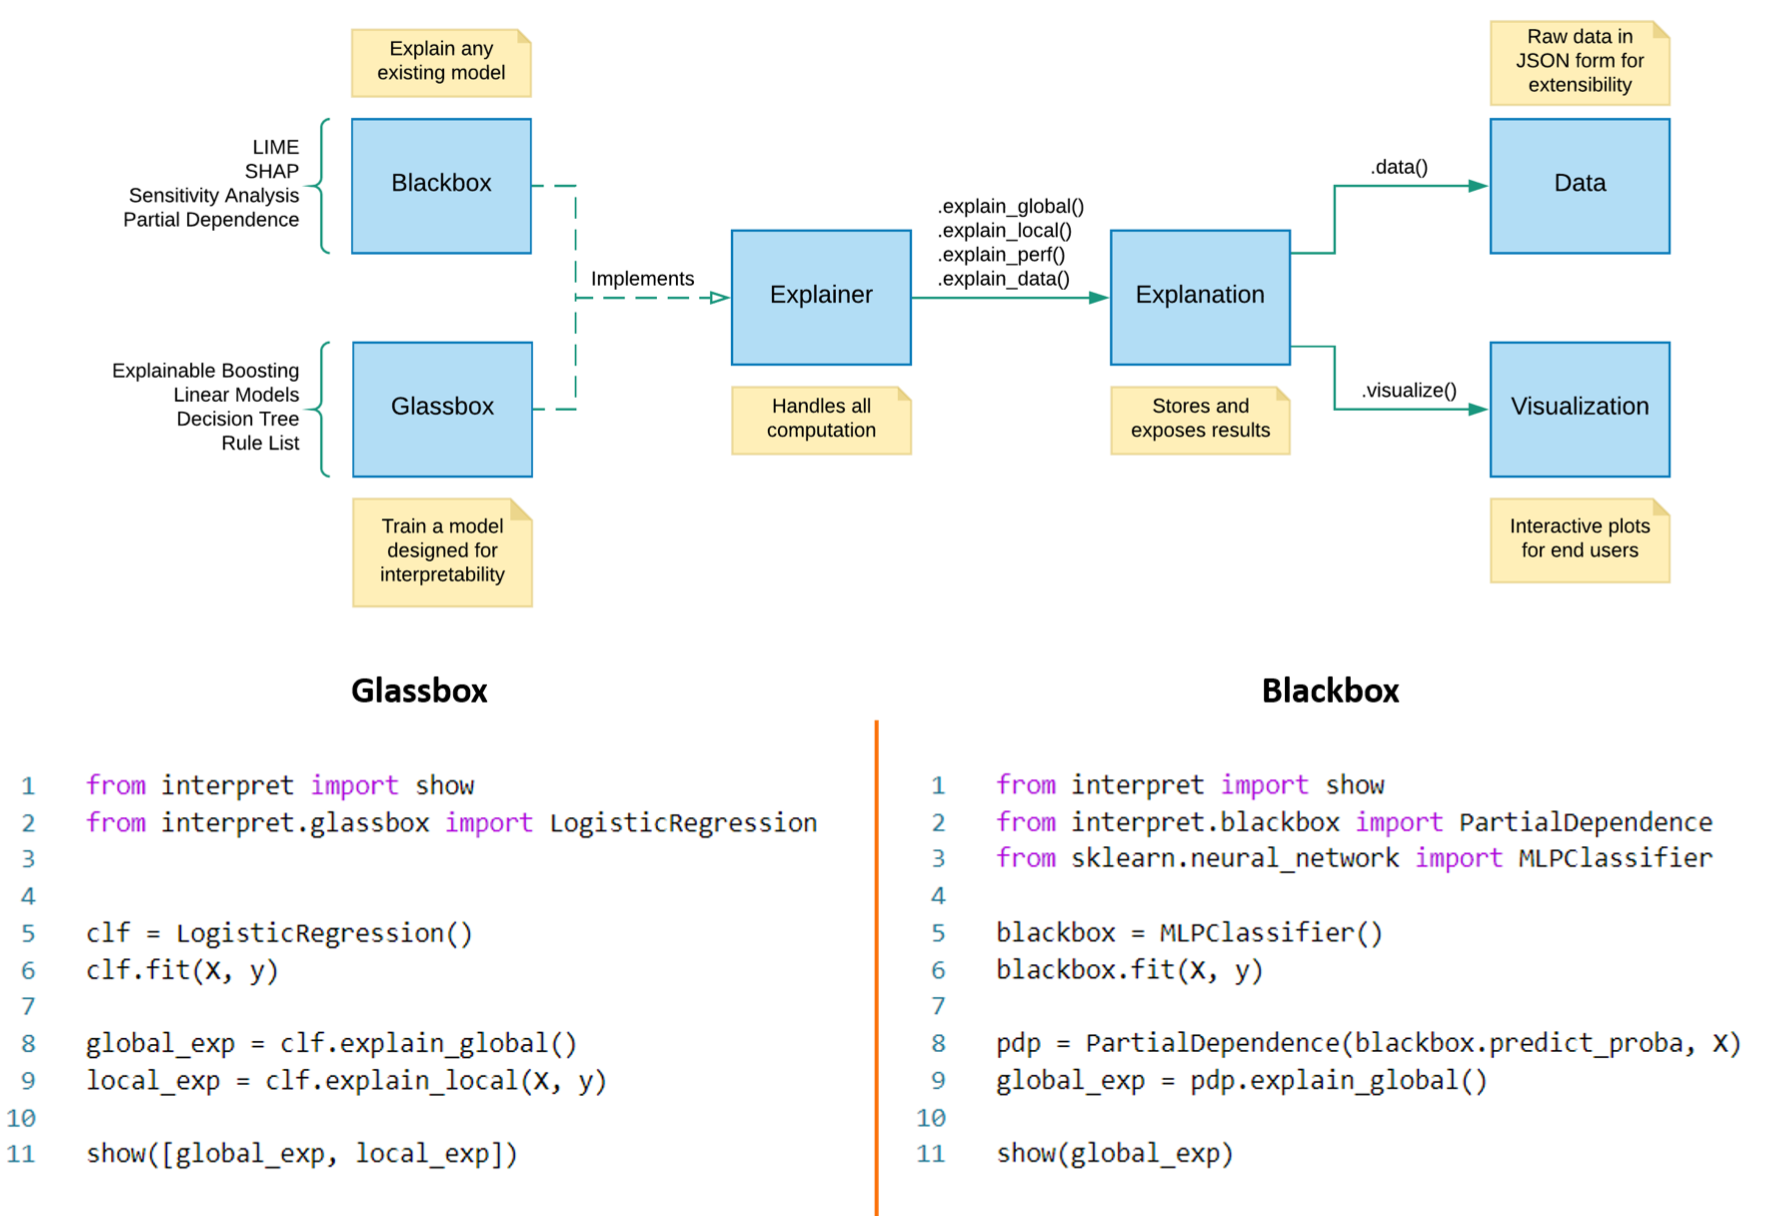
    </div>
</div>

# GAM and GA2M
 <div style="width: 100%; overflow: hidden;">
     <div style="width: 50%; float: top; margin: 0 auto;">
         GAM: General Additive Models
         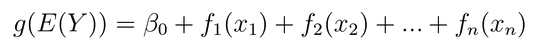
    </div>
     <div style="width: 50%; float: bottom; margin: 0 auto;">
         GA2M: General Additive Models with interactions
         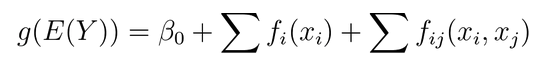 
    </div>
</div>
- EBM is a fast implementation of the GA2M algorithm and can automatically detect and include pairwise interaction terms

# Explainable Boosting Machine
 <div style="width: 100%; overflow: hidden;">
     <div style="width: 50%; float: left;">
         <ul>
             <li>Model is additive</li>
             <li>Each shape function (tree) uses only 1 feature</li>
             <li>Boosting proedure restricted to train on one feature at a time in round-robin fashion using a very low learning rate so that feature order does not matter</li>
             <li>"bagged boosted bagged shallow tree"</li>
         </ul>
    </div>
     <div style="width: 50%; float: right;">
         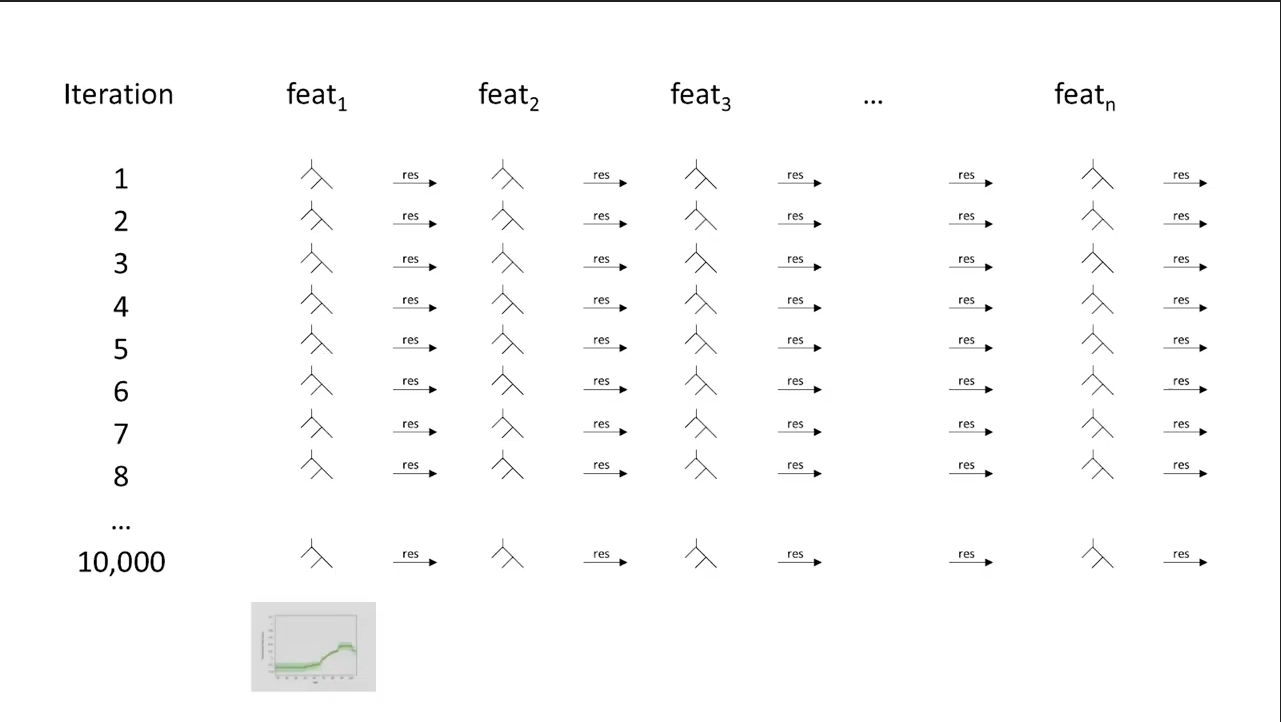 
    </div>
</div>

# Explainable Boosting Machine
 <div style="width: 100%; overflow: hidden;">
     <div style="width: 50%; float: left; margin: 0 auto;">
         Prediction Flow
         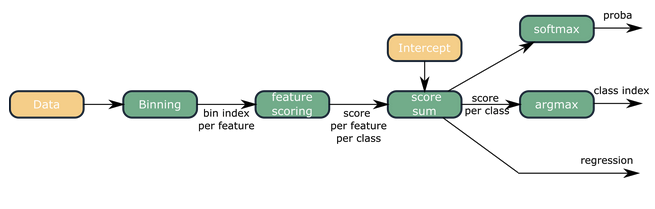
    </div>
     <div style="width: 50%; float: right; margin: 0 auto;">
         Prediction Example
         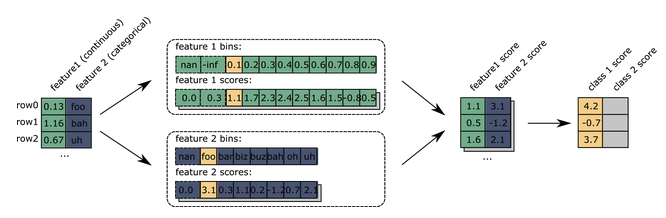 
    </div>
</div>

# Model Performance of EBM

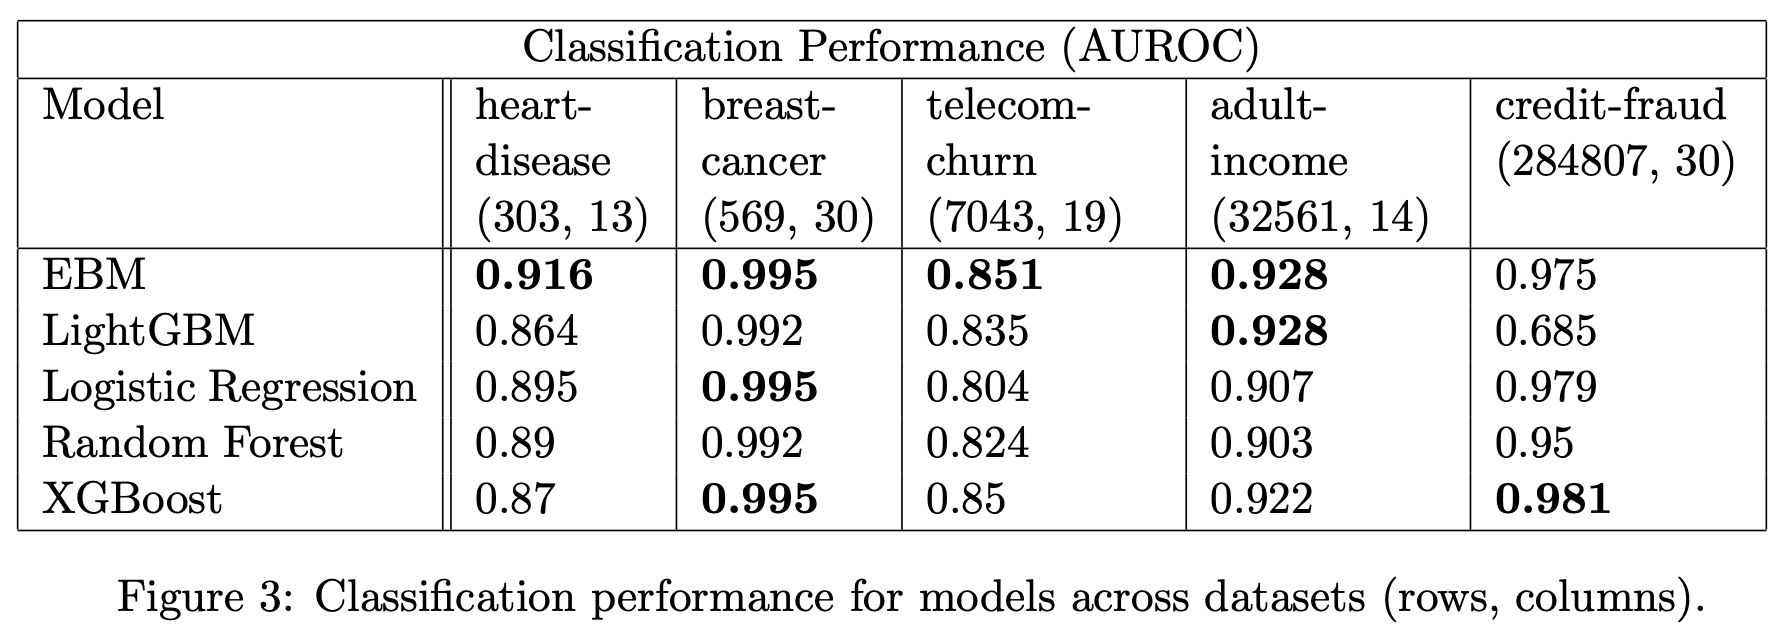

# Further Reading
- Paper: https://arxiv.org/abs/1909.09223
- Whitepaper: https://www.microsoft.com/en-us/research/uploads/prod/2020/05/InterpretML-Whitepaper.pdf
- Github: https://github.com/interpretml/interpret
- Blog: https://blog.oakbits.com/ebm-algorithm.html
- Video: https://www.youtube.com/watch?v=MREiHgHgl0k

In [4]:
# Ref: https://nbviewer.org/github/interpretml/interpret/blob/master/benchmarks/EBM%20Classification%20Comparison.ipynb
def load_adult_data():
    df = pd.read_csv(
        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
        header=None)
    df.columns = [
        "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
        "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
        "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
    ]
    train_cols = df.columns[0:-1]
    label = df.columns[-1]
    X_df = df[train_cols]
    y_df = df[label].apply(lambda x: 0 if x == " <=50K" else 1)

    return X_df, y_df

In [5]:
SEED = 42
np.random.seed(SEED)
X, y = load_adult_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)
ebm = ExplainableBoostingClassifier(random_state=SEED)
ebm.fit(X_train, y_train)
preds = ebm.predict(X_test)
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      5187
           1       0.67      0.79      0.72      1326

    accuracy                           0.88      6513
   macro avg       0.80      0.84      0.82      6513
weighted avg       0.89      0.88      0.88      6513



In [6]:
hist = ClassHistogram().explain_data(X_train, y_train, name = 'Train Data')
ebm_global = ebm.explain_global(name="EBM Global Explanation")
ebm_local = ebm.explain_local(X[:10], y[:10], name="Local Explanation (Selected)")
ebm_perf = ROC(ebm.predict_proba).explain_perf(X_test, y_test, "EBM ROC")
show([hist, ebm_global, ebm_local, ebm_perf])

/usr/local/Caskroom/miniforge/base/envs/interpretml/lib/python3.9/site-packages/interpret/visual/udash.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
/usr/local/Caskroom/miniforge/base/envs/interpretml/lib/python3.9/site-packages/interpret/visual/udash.py:6: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
/usr/local/Caskroom/miniforge/base/envs/interpretml/lib/python3.9/site-packages/interpret/visual/udash.py:7: UserWarning: 
The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`
  import dash_table as dt

<!-- http://127.0.0.1:7001/5148385472/ -->
 Open in new window